In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from IPython.display import clear_output
from collections import defaultdict

In [0]:
class LeNet(nn.Module): 
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.activation1 = nn.ELU(alpha=1.0, inplace=False)
    
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.activation2 = nn.ELU(alpha=1.0, inplace=False)

        self.fc1 = nn.Linear(5*5*16, 120)
        self.activation3 = nn.ELU(alpha=1.0, inplace=False)
        self.fc2 = nn.Linear(120, 84)
        self.activation4 = nn.ELU(alpha=1.0, inplace=False)
        self.fc3 = nn.Linear(84, 10)

        self.sm = nn.Softmax(1)
        
    def forward(self, x):
        x = F.avg_pool2d(self.activation1(self.conv1(x)), (2, 2))
        x = F.avg_pool2d(self.activation2(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.activation3(self.fc1(x))
        x = self.activation4(self.fc2(x))
        x = self.fc3(x)
        x = self.sm(x)

        return x
    
    def num_flat_features(self, x): # function which return numbers of features of convolution layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [0]:
cuda = torch.device('cuda')

In [0]:
net = LeNet().to(cuda) # creating model
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (activation1): ELU(alpha=1.0)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (activation2): ELU(alpha=1.0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (activation3): ELU(alpha=1.0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (activation4): ELU(alpha=1.0)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)


In [0]:
# net.load_state_dict(torch.load('weights.pt')) # If you have weights you can load them here

In [0]:
criterion = nn.CrossEntropyLoss() # creating loss function
optimizer = optim.SGD(net.parameters(), lr=0.08, momentum=0.7) # creating optimizer 
epochs = 1000

In [0]:
train_loader = torch.utils.data.DataLoader( # downloading and uploading data
  torchvision.datasets.MNIST('./data/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((28, 28), interpolation=2), # resizing oringal images as they have shape (32, 32) when model has input (28, 28)
                               torchvision.transforms.ToTensor(), # transforming image from numpy array to pytorch tensor
                               torchvision.transforms.Normalize( # normalizing images
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=32, shuffle=False)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!





In [0]:
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/mnist', train=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((28, 28), interpolation=2),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=10000, shuffle=False)

In [0]:
test_inputs, test_labels = iter(test_loader).next() # get all test data
test_inputs = test_inputs.to(cuda)
test_labels = test_labels.to(cuda)

In [0]:
%%time
finished = False # variable which represents whether the model achieved defined accuracy 

# lists which store training history
train_loss_history = [] 
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(epochs):
    running_train_loss = 0.0
    running_train_accuracy = 0.0

    running_test_loss = 0.0
    running_test_accuracy = 0.0

    if not finished:
        for i, data in enumerate(train_loader, 0):
            # clear_output()
            # print('i: {}'.format(i))

            inputs, labels = data # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.to(cuda)
            labels = labels.to(cuda)

            optimizer.zero_grad() # zero the parameter gradients

            # forward + backward + optimize
            outputs = net(inputs)
            # print(outputs.shape)
            test_outputs = net(test_inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            test_loss = criterion(test_outputs, test_labels) # calculating test loss
            
            # calculating accuracy
            train_accuracy = (outputs.argmax(1) == labels).sum().item() / outputs.shape[0]
            test_accuracy = (test_outputs.argmax(1) == test_labels).sum().item() / test_outputs.shape[0]

            running_train_accuracy += train_accuracy
            running_train_loss += loss.item()

            running_test_accuracy += test_accuracy
            running_test_loss += test_loss.item()


            # print statistics
            if i % 25 == 24:    # print every 25 mini-batches
                print('[%d, %5d] \nTrain: \n\tloss: %.3f, accuracy: %.3f\nTest: \n\tloss: %.3f, accuracy: %.3f' %
                    (epoch + 1, i + 1, running_train_loss / 25, running_train_accuracy / 25,
                                      running_test_loss / 25, running_test_accuracy / 25))

                if running_test_accuracy / 25 > 0.95 and running_train_accuracy / 25 > 0.95: # check whether we achieved established accuracy
                    finished = True
                    break

                # adding stats to logs
                train_loss_history.append(running_train_loss)
                train_accuracy_history.append(running_train_accuracy)
                test_loss_history.append(running_test_loss)
                test_accuracy_history.append(running_test_accuracy)

                running_train_loss = 0.0
                running_train_accuracy = 0.0

                running_test_loss = 0.0
                running_test_accuracy = 0.0

print('Finished Training')

[1,    25] 
Train: 
	loss: 2.302, accuracy: 0.119
Test: 
	loss: 2.302, accuracy: 0.111
[1,    50] 
Train: 
	loss: 2.300, accuracy: 0.174
Test: 
	loss: 2.300, accuracy: 0.170
[1,    75] 
Train: 
	loss: 2.297, accuracy: 0.228
Test: 
	loss: 2.297, accuracy: 0.232
[1,   100] 
Train: 
	loss: 2.287, accuracy: 0.425
Test: 
	loss: 2.287, accuracy: 0.401
[1,   125] 
Train: 
	loss: 2.202, accuracy: 0.419
Test: 
	loss: 2.197, accuracy: 0.427
[1,   150] 
Train: 
	loss: 1.876, accuracy: 0.609
Test: 
	loss: 1.893, accuracy: 0.605
[1,   175] 
Train: 
	loss: 1.807, accuracy: 0.659
Test: 
	loss: 1.809, accuracy: 0.662
[1,   200] 
Train: 
	loss: 1.744, accuracy: 0.728
Test: 
	loss: 1.778, accuracy: 0.690
[1,   225] 
Train: 
	loss: 1.759, accuracy: 0.710
Test: 
	loss: 1.743, accuracy: 0.723
[1,   250] 
Train: 
	loss: 1.735, accuracy: 0.729
Test: 
	loss: 1.730, accuracy: 0.734
[1,   275] 
Train: 
	loss: 1.732, accuracy: 0.734
Test: 
	loss: 1.718, accuracy: 0.746
[1,   300] 
Train: 
	loss: 1.683, accuracy:

In [0]:
outputs[:5]

tensor([[9.9999e-01, 2.3415e-19, 3.1543e-16, 1.7316e-16, 5.2556e-22, 9.1525e-06,
         4.2478e-07, 3.5361e-14, 1.4676e-15, 1.2249e-18],
        [8.8947e-18, 2.6484e-20, 1.0846e-20, 4.7163e-17, 6.8483e-13, 5.2046e-14,
         6.2743e-23, 3.7701e-10, 5.7223e-11, 1.0000e+00],
        [1.3606e-10, 7.8210e-13, 3.5022e-10, 8.9383e-17, 1.1914e-09, 6.8660e-11,
         1.0000e+00, 2.6890e-16, 2.8743e-09, 1.4396e-16],
        [1.0000e+00, 4.6028e-14, 7.1525e-09, 1.1638e-08, 6.9189e-16, 9.8114e-09,
         8.4396e-08, 4.0347e-11, 5.1916e-09, 4.4079e-13],
        [8.3149e-18, 1.4234e-11, 3.5094e-10, 6.5563e-12, 9.7165e-19, 1.7772e-16,
         2.8041e-19, 1.0000e+00, 9.7329e-15, 5.0028e-16]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [0]:
outputs.shape

torch.Size([32, 10])

In [0]:
(labels == outputs.argmax(1)).sum() / 

tensor(30, device='cuda:0')

In [0]:
outputs.argmax(1)

tensor([0, 9, 6, 0, 7, 1, 4, 2, 4, 8, 3, 4, 1, 5, 9, 6, 1, 7, 9, 8, 1, 9, 6, 0,
        0, 1, 8, 2, 7, 3, 3, 4], device='cuda:0')

In [0]:
(outputs.argmax(1) == labels).sum().item() / outputs.shape[0]

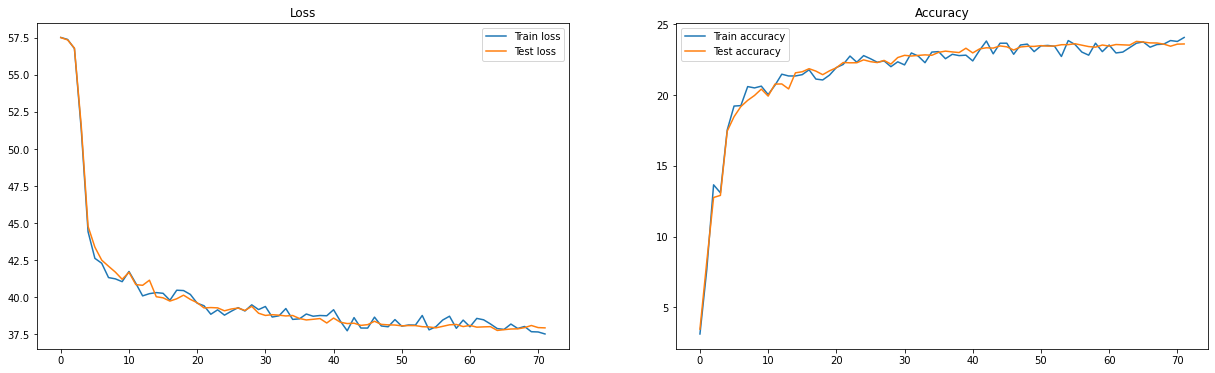

In [0]:
f, ax = plt.subplots(1, 2, figsize=(21, 6))

# n = len(train_loss_history)
ax[0].plot(train_loss_history, label='Train loss')
ax[0].plot(test_loss_history, label='Test loss')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(train_accuracy_history, label='Train accuracy')
ax[1].plot(test_accuracy_history, label='Test accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()

f.savefig('res.png')

In [0]:
# creating another data loader with batch size 1 to get loss seperately for each item
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/mnist', train=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((28, 28), interpolation=2),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=False)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/mnist', train=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((28, 28), interpolation=2),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=False)

In [0]:
res = np.zeros((70000, 4)) # here will be stored (image index, image loss, predicted label, true label)
for i, item in enumerate(train_loader, 0):
    # clear_output()
    # print('Current: {}'.format(i))
    img, labels_true = item
    img = img.to(cuda)
    labels_true = labels_true.to(cuda)

    labels_pred = net(img)
    loss = criterion(labels_pred, labels_true)

    res[i] = torch.tensor([i, loss.item(), labels_pred.argmax(1).item(), labels_true.item()])

for i, item in enumerate(test_loader, 60000):
    # clear_output()
    # print('Current: {}'.format(i))

    img, labels_true = item
    img = img.to(cuda)
    labels_true = labels_true.to(cuda)

    labels_pred = net(img)
    loss = criterion(labels_pred, labels_true)

    res[i] = torch.tensor([i, loss.item(), labels_pred.argmax().item(), labels_true.item()])

In [0]:
indxs_worst = res[:, 1].argsort()[-10:][::-1] # indexes of 10 images with the biggest loss
worst = res[np.sort(indxs_worst)]

In [0]:
unique = np.unique(worst[:, 2]) # all unique classes in worst images

# here we get 5 pictures with lowest loss in classes where was one or more image with the highest loss
# and store indexes of images in dictionary d – {index: class}
d = defaultdict(int)
for class_ in unique:
    class_res = res[res[:, 2] == class_]
    class_indxs = class_res[:, 1].argsort()[:5]
    indxs = class_res[class_indxs][:, 0]
    
    for indx in indxs:
        d[indx] = class_

In [0]:
imgs_worst = [] # images with the larges loss will be stored here
imgs_best = defaultdict(list) # stores images with lowest loss for particular class – {class: list of 5 images}

# in next lines we iterate over dataset and save appropriate images
for i, item in enumerate(train_loader, 0): 
    # clear_output()
    # print('Current: {}'.format(i))
    if i in indxs_worst:
        imgs_worst.append(item[0])

    if i in d.keys():
        imgs_best[d[i]].append(item[0])
        
for i, item in enumerate(test_loader, 60000):
    # clear_output()
    # print('Current: {}'.format(i))
    if i in indxs_worst:
        imgs_worst.append(item[0])

    if i in d.keys():
        imgs_best[d[i]].append(item[0])

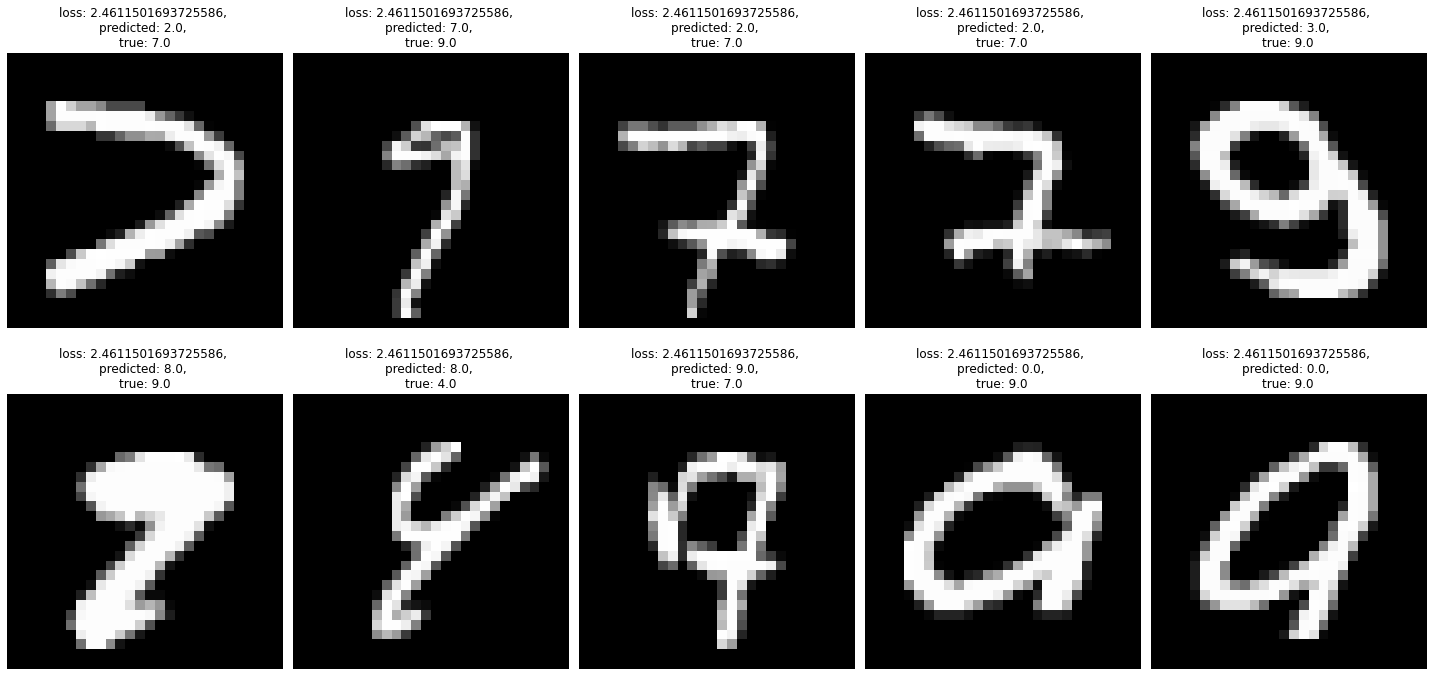

In [0]:
# visualisation of worst images
f, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    ax[i//5, i%5].imshow(imgs_worst[i].reshape((28, 28)), cmap='gray')
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title('loss: {}, \npredicted: {}, \ntrue: {}'.format(*worst[i, 1:]))
    
plt.tight_layout()
f.savefig('worst.png')

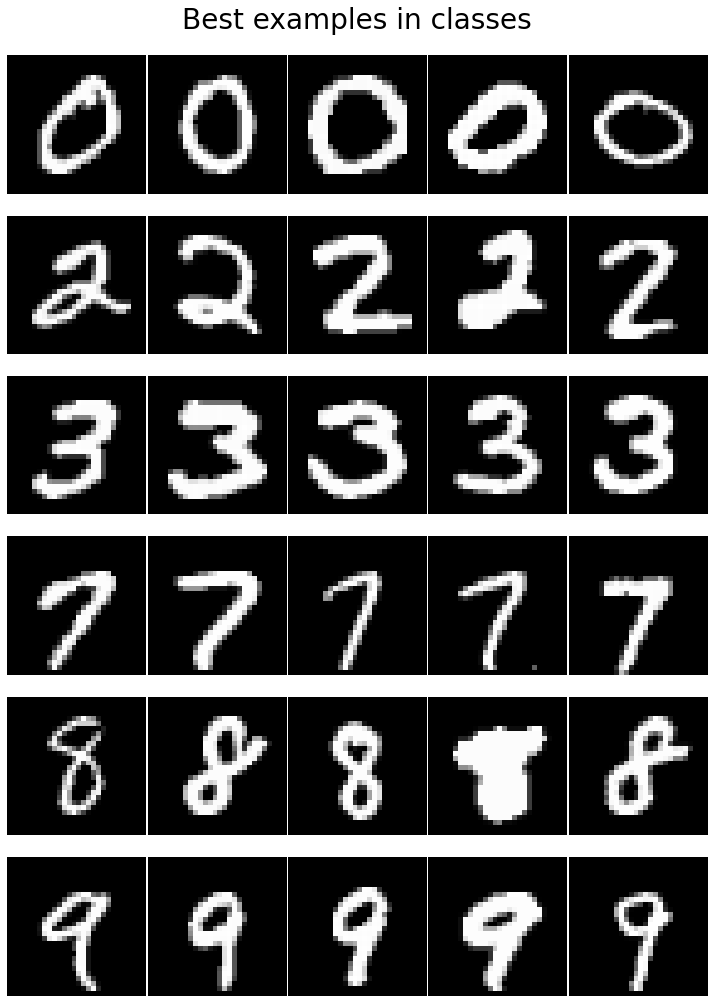

In [0]:
f, ax = plt.subplots(unique.shape[0], 5, figsize=(11.25, 15))
for i, class_ in enumerate(unique):
    for j, img in enumerate(imgs_best[class_]):
        ax[i, j].imshow(img.reshape((28, 28)), cmap='gray')
        ax[i, j].axis('off')

plt.tight_layout(pad=5.5, w_pad=0.2, h_pad=0.1)
fig = plt.gcf();
fig.suptitle("Best examples in classes", fontsize=28);
f.savefig('best.png')

------